In [1]:
import h5py
import copy
import lmfit
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from rich.progress import Progress
from scipy.stats import binned_statistic
from utils.plot_utils import set_fontsize
from utils.hdf_utils import load_measurement_data_devices_attrs

In [88]:
def ratio_with_error(a,b,σa,σb):
    ratio = a/b
    err = ratio * np.sqrt((σa/a)**2 + (σb/b)**2)
    return ratio, err

In [2]:
hdf_dir = Path("../data")

In [3]:
yag_channel = 0
pmt_channel = 1
pd_channel = 2
pdn_channel = 3
shutter_channel = 4
pdrc_channel = 5

In [79]:
fname = "2021_3_19.hdf"

with h5py.File(hdf_dir / fname, 'r') as f:
    dset_names = list(f.keys())
    for idn, name in enumerate(f.keys()):
        print(f"{idn:<2} <> {name:<60} : {len(f[name]['readout']['PXIe-5171'])}")

0  <> 1616180661 find R0 F1                                        : 716
1  <> 1616181133 check yag focus                                   : 1131
2  <> 1616182283 yag qswitch                                       : 701
3  <> 1616182527 yag qswitch                                       : 401
4  <> 1616182801 scan P2 F1                                        : 481
5  <> 1616183341 scan P2 F1 with shutter (R0 F1 DET and J12 J23 microwaves) : 3301
6  <> 1616184204 scan P2 F1 with shutter  no phase modulation on RC (R0 F1 DET and J12 J23 microwaves) : 5061
7  <> 1616186518 scan P2 F1 with shutter with phase modulation on RC (R0 F1 DET and J12 J23 microwaves) : 4001
8  <> 1616187747 scan P2 F1 with shutter with phase modulation on RC (R0 F1 DET and J12 J23 microwaves) : 41
9  <> 1616187813 scan P2 F1 with shutter with phase modulation on RC (R0 F1 DET and J12 J23 microwaves) : 4001
10 <> 1616191987 scan P2 F1 with shutter with phase modulation on RC and DET (R0 F1 DET and J12 J23 microwaves

## YAG focal length

In [5]:
dset_name = dset_names[1]
devices = ()

In [6]:
slice_flm  = np.s_[-250:]
slice_absm = np.s_[-500:]
slice_fli  = np.s_[100:]
slice_absi = np.s_[10:]

In [56]:
pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dset_name, devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])

norm_data = -pd_data/pdn_data

In [57]:
scan_parameter = 'PXIe5171 Dummyfunc'

In [58]:
scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter].split(' ')[-1]) for idx in range(1,len(pxie)+1)])

In [59]:
yag_cutoff = 250
ptn_cutoff = 19000
abs_cutoff = 3
fl_cutoff = -5000
shutter_cutoff = 10000

In [60]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff

mask = mask_yag | mask_pdn | mask_abs | mask_fl

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

In [61]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

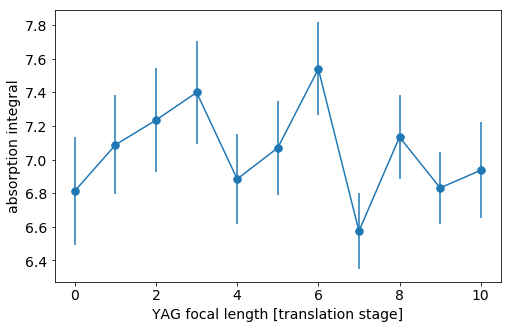

In [66]:
bin_width = np.diff(np.unique(scan_parameters))[0]
bins = np.arange(np.unique(scan_parameters).min()-bin_width/2, np.unique(scan_parameters).max()+bin_width, bin_width)
stat, bin_edges, bin_number = binned_statistic(scan_parameters, absorption_integral, 
                                               lambda x: np.nanmean(x), bins = bins) 
err, bin_edges, bin_number = binned_statistic(scan_parameters, absorption_integral, 
                                              lambda x: np.nanstd(x)/(np.sqrt(len(x))-1), bins = bins) 

bin_means = bin_edges[:-1]+bin_width/2

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, stat, yerr = err, fmt = '.', ms = 15, linestyle = '-')

ax.set_xlabel('YAG focal length [translation stage]')
ax.set_ylabel('absorption integral')
set_fontsize(ax, 14)

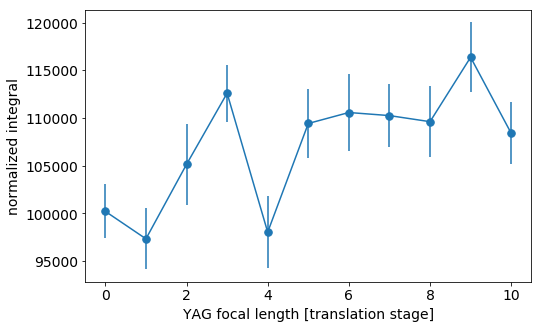

In [67]:
bin_width = np.diff(np.unique(scan_parameters))[0]
bins = np.arange(np.unique(scan_parameters).min()-bin_width/2, np.unique(scan_parameters).max()+bin_width, bin_width)
stat, bin_edges, bin_number = binned_statistic(scan_parameters, fluorescence_integral/absorption_integral, 
                                               lambda x: np.nanmean(x), bins = bins) 
err, bin_edges, bin_number = binned_statistic(scan_parameters, fluorescence_integral/absorption_integral, 
                                              lambda x: np.nanstd(x)/(np.sqrt(len(x))-1), bins = bins) 

bin_means = bin_edges[:-1]+bin_width/2

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, stat, yerr = err, fmt = '.', ms = 15, linestyle = '-')

ax.set_xlabel('YAG focal length [translation stage]')
ax.set_ylabel('normalized integral')
set_fontsize(ax, 14)

## YAG Q-switch

In [69]:
dset_name = dset_names[3]
devices = ()

In [70]:
slice_flm  = np.s_[-250:]
slice_absm = np.s_[-500:]
slice_fli  = np.s_[100:]
slice_absi = np.s_[10:]

In [71]:
pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dset_name, devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])

norm_data = -pd_data/pdn_data

In [72]:
scan_parameter = 'PXIe5171 Dummyfunc'

In [73]:
scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter].split(' ')[-1]) for idx in range(1,len(pxie)+1)])

In [74]:
yag_cutoff = 250
ptn_cutoff = 19000
abs_cutoff = 3
fl_cutoff = -5000
shutter_cutoff = 10000

In [75]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff

mask = mask_yag | mask_pdn | mask_abs | mask_fl

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

In [76]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

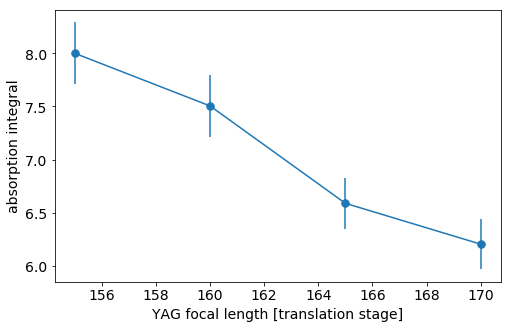

In [77]:
bin_width = np.diff(np.unique(scan_parameters))[0]
bins = np.arange(np.unique(scan_parameters).min()-bin_width/2, np.unique(scan_parameters).max()+bin_width, bin_width)
stat, bin_edges, bin_number = binned_statistic(scan_parameters, absorption_integral, 
                                               lambda x: np.nanmean(x), bins = bins) 
err, bin_edges, bin_number = binned_statistic(scan_parameters, absorption_integral, 
                                              lambda x: np.nanstd(x)/(np.sqrt(len(x))-1), bins = bins) 

bin_means = bin_edges[:-1]+bin_width/2

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, stat, yerr = err, fmt = '.', ms = 15, linestyle = '-')

ax.set_xlabel('YAG focal length [translation stage]')
ax.set_ylabel('absorption integral')
set_fontsize(ax, 14)

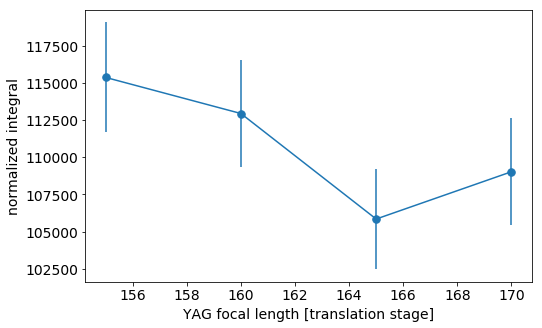

In [78]:
bin_width = np.diff(np.unique(scan_parameters))[0]
bins = np.arange(np.unique(scan_parameters).min()-bin_width/2, np.unique(scan_parameters).max()+bin_width, bin_width)
stat, bin_edges, bin_number = binned_statistic(scan_parameters, fluorescence_integral/absorption_integral, 
                                               lambda x: np.nanmean(x), bins = bins) 
err, bin_edges, bin_number = binned_statistic(scan_parameters, fluorescence_integral/absorption_integral, 
                                              lambda x: np.nanstd(x)/(np.sqrt(len(x))-1), bins = bins) 

bin_means = bin_edges[:-1]+bin_width/2

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, stat, yerr = err, fmt = '.', ms = 15, linestyle = '-')

ax.set_xlabel('YAG focal length [translation stage]')
ax.set_ylabel('normalized integral')
set_fontsize(ax, 14)

## Scan P2 F1 RC (R0 F1 DET and J12, J23 microwaves)
39 mW P2 F1  
Phase modulation on P2 F1

In [98]:
dset_name = dset_names[5]
devices = ()

In [99]:
slice_flm  = np.s_[-250:]
slice_absm = np.s_[-500:]
slice_fli  = np.s_[100:]
slice_absi = np.s_[10:]

In [100]:
pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dset_name, devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])

norm_data = -pd_data/pdn_data

C:\Users\CeNTREX\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


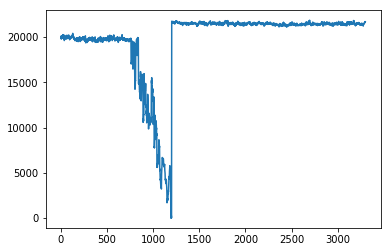

In [107]:
plt.plot(pdn_data.mean(axis = 1))

In [101]:
scan_parameter = 'Laser Lock 1 SetLockPointSeed1'
scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])

In [108]:
yag_cutoff = 250
ptn_cutoff = 18000
abs_cutoff = 4
fl_cutoff = -5000

In [109]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff

mask = mask_yag | mask_pdn | mask_abs | mask_fl

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

C:\Users\CeNTREX\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in subtract
  


In [110]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

mask_sh_open = shutter_data.max(axis = 1) > 10000
mask_sh_closed = ~mask_sh_open

bin_width = np.diff(np.unique(scan_parameters)).min()
bins = np.arange(np.unique(scan_parameters).min()-bin_width/2, np.unique(scan_parameters).max()+bin_width, bin_width)

results = []
for m in [mask_sh_open, mask_sh_closed]:
    stat, bin_edges, bin_number = binned_statistic(scan_parameters[m], (fluorescence_integral/absorption_integral)[m], lambda x: np.nanmean(x), bins = bins)
    err, _, _ = binned_statistic(scan_parameters[m], (fluorescence_integral/absorption_integral)[m], lambda x: np.nanstd(x)/np.sqrt(len(x)-1), bins = bins)
    results.append((stat, err, bin_number))
    
bin_means = bin_edges[:-1]+bin_width/2

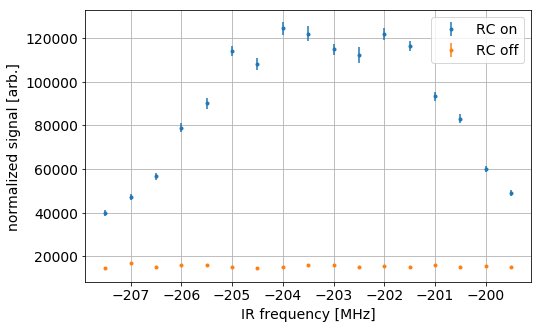

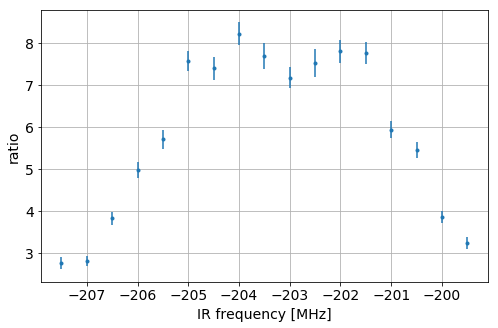

In [111]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, results[0][0], yerr = results[0][1], fmt = '.', label = 'RC on')
ax.errorbar(bin_means, results[1][0], yerr = results[1][1], fmt = '.', label = 'RC off')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')
ax.legend(fontsize = 14)

ax.grid(True)
set_fontsize(ax, 14)

ratio, err = ratio_with_error(results[0][0], results[1][0], results[0][1], results[1][1])

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, ratio, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('ratio')

ax.grid(True)

set_fontsize(ax, 14)

In [112]:
data_phasemod = [bin_means, results, (ratio, err)]

## Scan P2 F1 RC (R0 F1 DET and J12, J23 microwaves)
39 mW P2 F1  
No phase modulation

In [113]:
dset_name = dset_names[6]
devices = ()

In [114]:
slice_flm  = np.s_[-250:]
slice_absm = np.s_[-500:]
slice_fli  = np.s_[100:]
slice_absi = np.s_[10:]

In [115]:
pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dset_name, devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])

norm_data = -pd_data/pdn_data

In [116]:
scan_parameter = 'Laser Lock 1 SetLockPointSeed1'
scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])

In [117]:
yag_cutoff = 250
ptn_cutoff = 19000
abs_cutoff = 4
fl_cutoff = -5000

In [118]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff

mask = mask_yag | mask_pdn | mask_abs | mask_fl

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

In [119]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

mask_sh_open = shutter_data.max(axis = 1) > 10000
mask_sh_closed = ~mask_sh_open

bin_width = np.diff(np.unique(scan_parameters)).min()
bins = np.arange(np.unique(scan_parameters).min()-bin_width/2, np.unique(scan_parameters).max()+bin_width, bin_width)

results = []
for m in [mask_sh_open, mask_sh_closed]:
    stat, bin_edges, bin_number = binned_statistic(scan_parameters[m], (fluorescence_integral/absorption_integral)[m], lambda x: np.nanmean(x), bins = bins)
    err, _, _ = binned_statistic(scan_parameters[m], (fluorescence_integral/absorption_integral)[m], lambda x: np.nanstd(x)/np.sqrt(len(x)-1), bins = bins)
    results.append((stat, err, bin_number))
    
bin_means = bin_edges[:-1]+bin_width/2

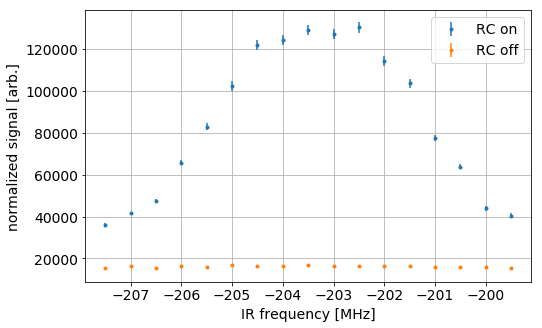

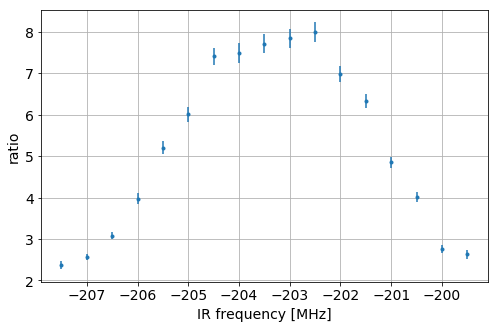

In [120]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, results[0][0], yerr = results[0][1], fmt = '.', label = 'RC on')
ax.errorbar(bin_means, results[1][0], yerr = results[1][1], fmt = '.', label = 'RC off')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')
ax.legend(fontsize = 14)

ax.grid(True)
set_fontsize(ax, 14)

ratio, err = ratio_with_error(results[0][0], results[1][0], results[0][1], results[1][1])

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, ratio, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('ratio')

ax.grid(True)

set_fontsize(ax, 14)

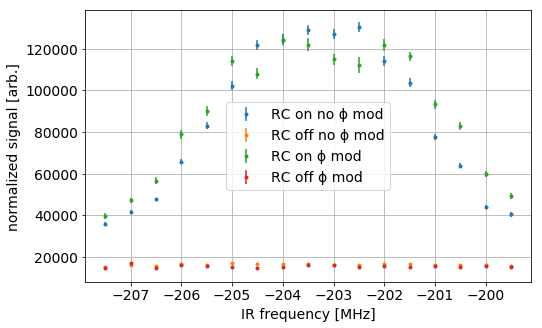

In [121]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, results[0][0], yerr = results[0][1], fmt = '.', label = 'RC on no ϕ mod')
ax.errorbar(bin_means, results[1][0], yerr = results[1][1], fmt = '.', label = 'RC off no ϕ mod')

r = data_phasemod[1]
ax.errorbar(bin_means, r[0][0], yerr = r[0][1], fmt = '.', label = 'RC on ϕ mod')
ax.errorbar(bin_means, r[1][0], yerr = r[1][1], fmt = '.', label = 'RC off ϕ mod')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')
ax.legend(fontsize = 14)

ax.grid(True)
set_fontsize(ax, 14)

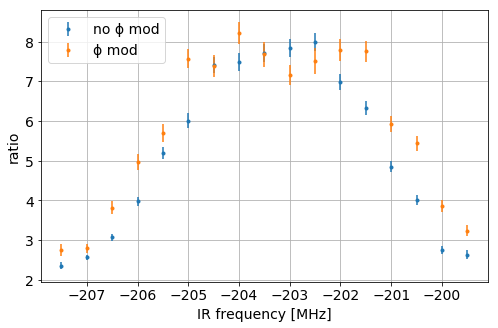

In [122]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, ratio, yerr = err, fmt = '.', label = 'no ϕ mod')

ra, re = data_phasemod[2]
ax.errorbar(bin_means, ra, yerr = re, fmt = '.', label=  'ϕ mod')


ax.legend(fontsize = 14)
ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('ratio')

ax.grid(True)

set_fontsize(ax, 14)

## Scan P2 F1 RC (R0 F1 DET and J12, J23 microwaves)
49 mW P2 F1  
Phase modulation on P2 F1

In [128]:
dset_name = dset_names[9]
devices = ()

In [129]:
slice_flm  = np.s_[-250:]
slice_absm = np.s_[-500:]
slice_fli  = np.s_[100:]
slice_absi = np.s_[10:]

In [130]:
pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dset_name, devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])

norm_data = -pd_data/pdn_data

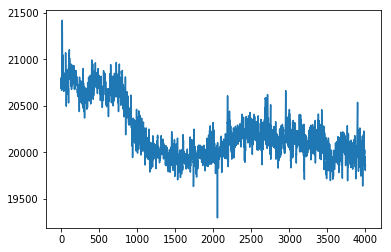

In [131]:
plt.plot(pdn_data.mean(axis = 1))

In [132]:
scan_parameter = 'Laser Lock 1 SetLockPointSeed1'
scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])

In [133]:
yag_cutoff = 250
ptn_cutoff = 18000
abs_cutoff = 4
fl_cutoff = -5000

In [134]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff

mask = mask_yag | mask_pdn | mask_abs | mask_fl

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

In [135]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

mask_sh_open = shutter_data.max(axis = 1) > 10000
mask_sh_closed = ~mask_sh_open

bin_width = np.diff(np.unique(scan_parameters)).min()
bins = np.arange(np.unique(scan_parameters).min()-bin_width/2, np.unique(scan_parameters).max()+bin_width, bin_width)

results = []
for m in [mask_sh_open, mask_sh_closed]:
    stat, bin_edges, bin_number = binned_statistic(scan_parameters[m], (fluorescence_integral/absorption_integral)[m], lambda x: np.nanmean(x), bins = bins)
    err, _, _ = binned_statistic(scan_parameters[m], (fluorescence_integral/absorption_integral)[m], lambda x: np.nanstd(x)/np.sqrt(len(x)-1), bins = bins)
    results.append((stat, err, bin_number))
    
bin_means = bin_edges[:-1]+bin_width/2

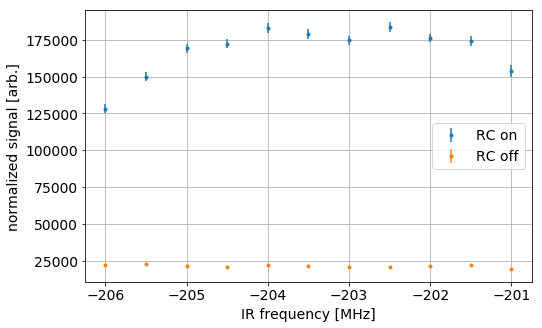

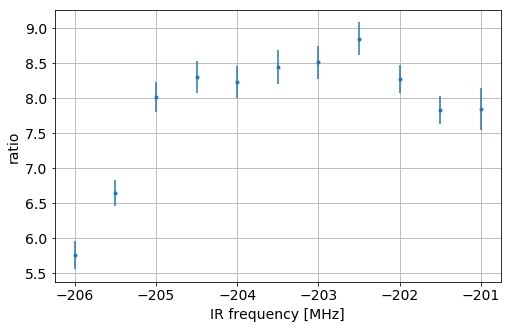

In [136]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, results[0][0], yerr = results[0][1], fmt = '.', label = 'RC on')
ax.errorbar(bin_means, results[1][0], yerr = results[1][1], fmt = '.', label = 'RC off')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')
ax.legend(fontsize = 14)

ax.grid(True)
set_fontsize(ax, 14)

ratio, err = ratio_with_error(results[0][0], results[1][0], results[0][1], results[1][1])

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, ratio, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('ratio')

ax.grid(True)

set_fontsize(ax, 14)